In [1]:
# -----------------------Kalman Filters - Direct Strapdown vs Quantum --------------
#  
#Take raw Direct strapdown results, as observation and raw GIRAFE as measurement update.
# 
# ---------------------------------------------------------------------------------
# Author: Christian Solgaard (DTU) 21/02-2024 
# ---------------------------------------------------------------------------------


from numba import jit, njit
import Direct_Strapdown as ds
from scipy.linalg import expm, sqrtm
import numpy as np
import copy
import scienceplots
from pathlib import Path 
import pandas as pd
import time
from scipy import interpolate
from dataclasses import dataclass
import pickle
import RTS as RTS
import matplotlib.pyplot as plt
plt.style.use(['science', 'grid', 'no-latex'])

params = {'axes.labelsize': 'x-large', 'axes.titlesize':'xx-large','xtick.labelsize':'large', 
          'ytick.labelsize':'large', 'legend.fontsize': 'x-large','mathtext.fontset':'stix', 'font.family':'STIXGeneral'}
plt.rcParams.update(params)

import warnings
# To ignore all warnings
warnings.filterwarnings("ignore")

file_path_DS = "../Results/DS_300Hz_150s_3_stages.pkl"

print(f"Loading DS results from: {file_path_DS}")
with open(file_path_DS, 'rb') as file: 
    DS = pickle.load(file)

file_path_girafe = "../Results/dg_GIRAFE_biscay_ref_profile_2019.pkl"
print(f"Loading DS results from: {file_path_girafe}")
with open(file_path_girafe, 'rb') as file: 
    DS_girafe = pickle.load(file)
DS_girafe["time"] = DS_girafe["time"] #- 7182 

    

Loading DS results from: ../Results/DS_300Hz_150s_3_stages.pkl
Loading DS results from: ../Results/dg_GIRAFE_biscay_ref_profile_2019.pkl


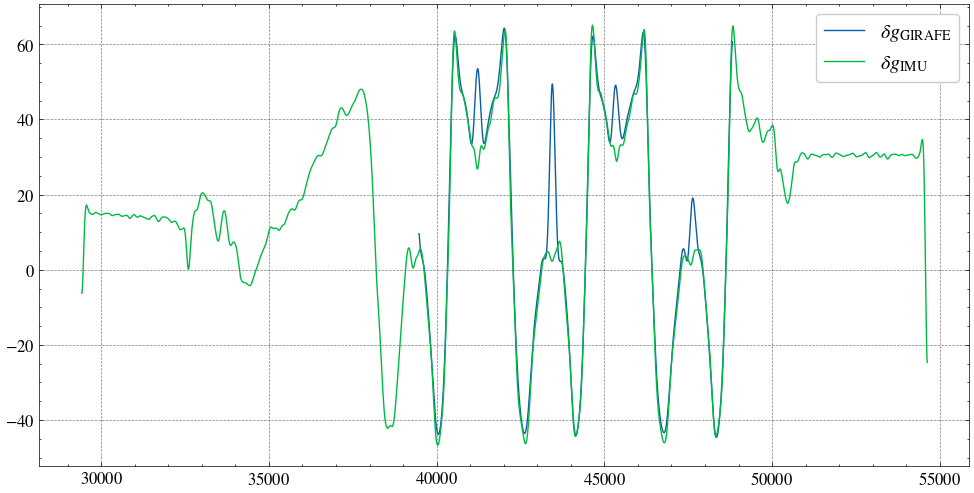

In [2]:
DS_girafe.keys()
plt.figure(figsize=(12,6))
plt.plot(DS_girafe["time"][700:-700], DS_girafe["fdg"][700:-700], label=r"$\delta g_{\mathrm{GIRAFE}}$")
plt.plot(ds.SOW2SOD(DS["time"]), DS["fdg"][:,2]-40, label=r"$\delta g_{\mathrm{IMU}}$")
plt.legend()



plt.show()

Loading DS results from: ../Results/RTS_IMAR_GIRAFE_RAW.pkl
Loading DS results from: ../Results/dg_GIRAFE_biscay_ref_profile_2019.pkl


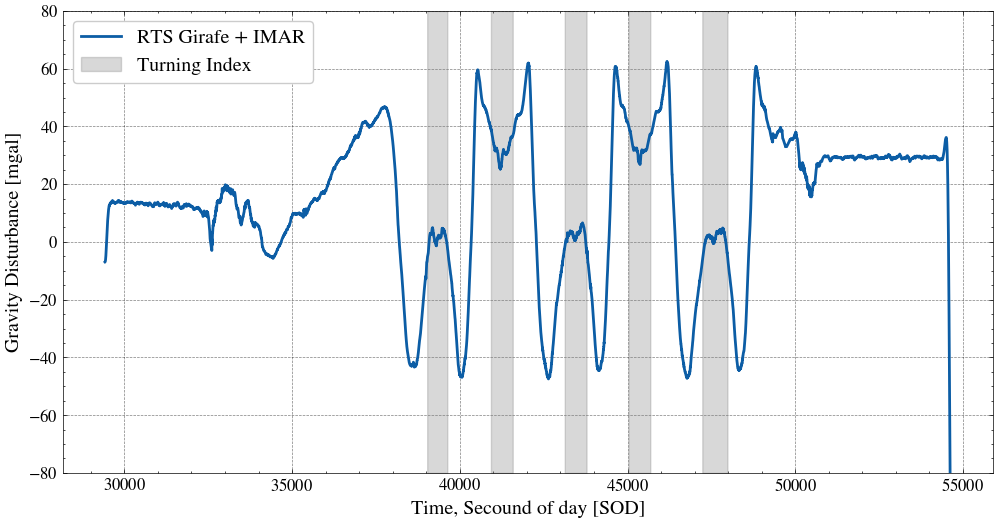

In [3]:
def rewritePDF2Tuple(PDF, index_start, index_end):       # Findes også i DS
    
    if isinstance(PDF, dict):  # Check if PDF is already a dictionary
        return {key: value[index_start:index_end] for key, value in PDF.items()}

    # Slice the DataFrame to remove the specified range from the start and end of each column
    PDF = PDF.iloc[index_start:index_end, :]

    # Reset the index to start from 0 again
    PDF = PDF.reset_index(drop=True)

    temp = {}
    for key, value in PDF.items():
        # temp[key] = value[index_start:index_end]
        temp[key] = value
    return temp
def workAround(): 
    keys = ["sfreq", "srate"]
    for i in range(len(keys)): 
        DS_girafe[keys[i]] = DS_girafe[keys[i]]*np.ones(DS_girafe["time"].shape)


file_path_DS = '../Results/RTS_IMAR_GIRAFE_RAW.pkl'

print(f"Loading DS results from: {file_path_DS}")
with open(file_path_DS, 'rb') as file: 
    rts_final = pickle.load(file)


file_path_girafe = "../Results/dg_GIRAFE_biscay_ref_profile_2019.pkl"
print(f"Loading DS results from: {file_path_girafe}")
with open(file_path_girafe, 'rb') as file: 
    DS_girafe = pickle.load(file)
workAround()
DS_girafe = rewritePDF2Tuple(DS_girafe, 200, -200)
cutoff = 1

test_const = 0

turning = {}
turning["T1"] = np.arange(50, 650)
turning["T2"] = np.arange(1950, 2600)
turning["T3"] = np.arange(4150, 4800)
turning["T4"] = np.arange(6050, 6700)
turning["T5"] = np.arange(8250, 9000)

# Create a mask to identify indices to keep
turning_idx = np.ones(len(DS_girafe["time"]))*70
for indices in turning.values():
    turning_idx[indices] = 0
boundaries = np.diff(turning_idx).nonzero()[0] + 1

plt.figure(figsize=(12,6))

plt.plot(rts_final["time"][cutoff:-cutoff], rts_final["profile"][cutoff:-cutoff,0], label="RTS Girafe + IMAR", linewidth=2)
# plt.plot(DS_girafe["time"], turning_idx, label="Turning Index", lw=2)

# Plot transparent grey areas for turning intervals
for i, (start, end) in enumerate(zip(boundaries[::2], boundaries[1::2])):
    plt.fill_between(DS_girafe["time"][start:end], -80, 80, color='grey', alpha=0.3, label="Turning Index" if i == 0 else None)

# plt.plot(DS_girafe["time"][500:-200-1], DS_girafe["dg"][500:-200], label="GIRAFE 130s", linewidth=2)
plt.legend(loc="upper left")
plt.ylim(-80,80)
plt.grid()
plt.xlabel("Time, Secound of day [SOD]")
plt.ylabel("Gravity Disturbance [mgal]")
plt.grid()

In [17]:
mean = 0  # Mean of the distribution
std_dev = 1  # Standard deviation of the distribution
size = 10  # Number of random values to generate

# Generate a vector of normally distributed random values
a = np.random.normal(mean, std_dev, size)
b = np.random.normal(mean, std_dev, size)

In [53]:
DS["fdg"][:,2]

array([33.76467474, 33.75548158, 33.7552821 , ..., 15.58087384,
       15.46857527, 15.37562124])

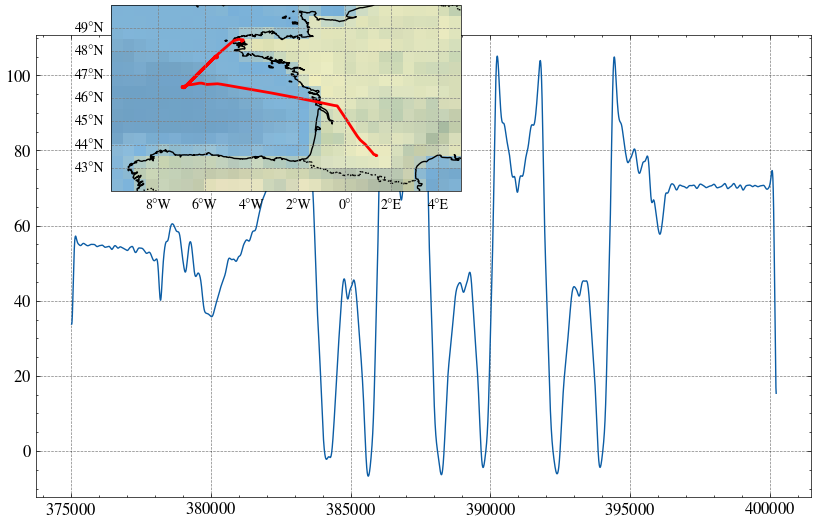

In [55]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Main plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(DS["time"], DS["fdg"][:,2])

# Inset axes
extent = [-10, 5, 42, 50]
axin2 = fig.add_axes([0.2, 0.6, 0.35, 0.35], projection=ccrs.PlateCarree(), zorder=2)
axin2.set_extent(extent)
axin2.add_feature(cfeature.COASTLINE)
axin2.add_feature(cfeature.BORDERS, linestyle=':')
axin2.stock_img()
axin2.plot(DS["lon"], DS["lat"], color="red", lw=2)

gl = axin2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=0.5, color='gray')
gl.xlabels_top = False
gl.ylabels_right = False

plt.show()



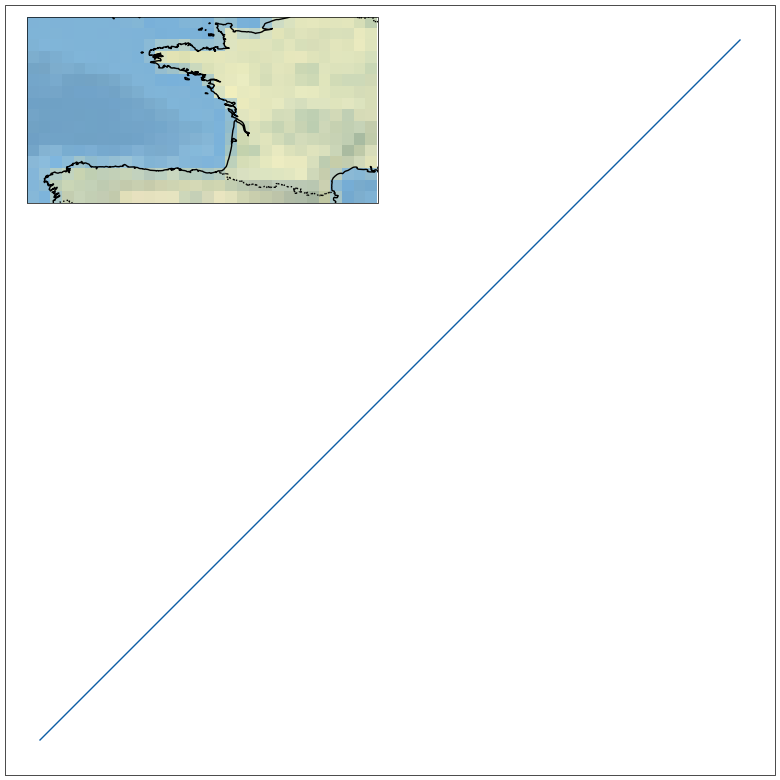

In [34]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Main plot
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10,10))
ax.plot(range(10))

# Inset axes
extent = [-10, 5, 42, 50]
axin2 = fig.add_axes([0.15, 0.6, 0.35, 0.35], projection=ccrs.PlateCarree(), zorder=2)
axin2.set_extent(extent)
axin2.add_feature(cfeature.COASTLINE)
axin2.add_feature(cfeature.BORDERS, linestyle=':')
axin2.stock_img()

plt.show()

